In [306]:
# Install additional packages for better forecasting models
!pip3 install --quiet prophet lightgbm optuna scikit-optimize


In [307]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

In [308]:
df_acorn_p = pd.read_parquet('../data/02_processed/daily_parquet_enhanced/acorn_p_enhanced.parquet')
df_acorn_c = pd.read_parquet('../data/02_processed/daily_parquet_enhanced/acorn_c_enhanced.parquet')
df_acorn_f = pd.read_parquet('../data/02_processed/daily_parquet_enhanced/acorn_f_enhanced.parquet')

In [309]:
# Train: 2012-10-29 → 2013-12-15 | Validation: 2013-12-16 → 2014-01-12 (28 days) | Forecasting: 2014-01-13 → 2014-02-13 (31 days)

def split_train_val_test(df, test_size=0.2, val_size=0.1):
    """
    Splits the DataFrame into train, validation, and test sets based on date.
    - Train: 70% of the data
    - Validation: 10% of the data
    - Test: 20% of the data
    """
    # Ensure 'Date' is sorted
    df = df.sort_values('Date').reset_index(drop=True)

    # Calculate split indices
    n = len(df)
    train_end = int(n * (1 - test_size - val_size))
    val_end = int(n * (1 - test_size))

    # Split the DataFrame
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df

# Split each ACORN DataFrame
train_acorn_c, val_acorn_c, test_acorn_c = split_train_val_test(df_acorn_c)
train_acorn_p, val_acorn_p, test_acorn_p = split_train_val_test(df_acorn_p)
train_acorn_f, val_acorn_f, test_acorn_f = split_train_val_test(df_acorn_f)

In [310]:
df_acorn_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     559 non-null    datetime64[ns]
 1   temperatureMax           559 non-null    float64       
 2   windBearing              559 non-null    int64         
 3   icon                     559 non-null    category      
 4   dewPoint                 559 non-null    float64       
 5   cloudCover               559 non-null    float64       
 6   windSpeed                559 non-null    float64       
 7   pressure                 559 non-null    float64       
 8   apparentTemperatureHigh  559 non-null    float64       
 9   precipType               559 non-null    category      
 10  visibility               559 non-null    float64       
 11  humidity                 559 non-null    float64       
 12  apparentTemperatureLow   559 non-nul

# LighGBM

In [311]:
print("--- Inspecting DataFrames and Date Ranges ---")
print(f"df_acorn_c | Min Date: {df_acorn_c['Date'].min()} | Max Date: {df_acorn_c['Date'].max()} | Rows: {len(df_acorn_c)}")
print(f"df_acorn_p | Min Date: {df_acorn_p['Date'].min()} | Max Date: {df_acorn_p['Date'].max()} | Rows: {len(df_acorn_p)}")
print(f"df_acorn_f | Min Date: {df_acorn_f['Date'].min()} | Max Date: {df_acorn_f['Date'].max()} | Rows: {len(df_acorn_f)}")

print("Splits for ACORN C:")
print(f"train_acorn_c | Min Date: {train_acorn_c['Date'].min()} | Max Date: {train_acorn_c['Date'].max()} | Rows: {len(train_acorn_c)}")
print(f"val_acorn_c   | Min Date: {val_acorn_c['Date'].min()} | Max Date: {val_acorn_c['Date'].max()} | Rows: {len(val_acorn_c)}")
print(f"test_acorn_c  | Min Date: {test_acorn_c['Date'].min()} | Max Date: {test_acorn_c['Date'].max()} | Rows: {len(test_acorn_c)}")

print("Splits for ACORN P:")
print(f"train_acorn_p | Min Date: {train_acorn_p['Date'].min()} | Max Date: {train_acorn_p['Date'].max()} | Rows: {len(train_acorn_p)}")
print(f"val_acorn_p   | Min Date: {val_acorn_p['Date'].min()} | Max Date: {val_acorn_p['Date'].max()} | Rows: {len(val_acorn_p)}")
print(f"test_acorn_p  | Min Date: {test_acorn_p['Date'].min()} | Max Date: {test_acorn_p['Date'].max()} | Rows: {len(test_acorn_p)}")

print("Splits for ACORN F:")
print(f"train_acorn_f | Min Date: {train_acorn_f['Date'].min()} | Max Date: {train_acorn_f['Date'].max()} | Rows: {len(train_acorn_f)}")
print(f"val_acorn_f   | Min Date: {val_acorn_f['Date'].min()} | Max Date: {val_acorn_f['Date'].max()} | Rows: {len(val_acorn_f)}")
print(f"test_acorn_f  | Min Date: {test_acorn_f['Date'].min()} | Max Date: {test_acorn_f['Date'].max()} | Rows: {len(test_acorn_f)}")


--- Inspecting DataFrames and Date Ranges ---
df_acorn_c | Min Date: 2012-07-01 00:00:00 | Max Date: 2014-01-12 00:00:00 | Rows: 559
df_acorn_p | Min Date: 2012-07-01 00:00:00 | Max Date: 2014-01-12 00:00:00 | Rows: 559
df_acorn_f | Min Date: 2012-07-01 00:00:00 | Max Date: 2014-01-12 00:00:00 | Rows: 559
Splits for ACORN C:
train_acorn_c | Min Date: 2012-07-01 00:00:00 | Max Date: 2013-07-26 00:00:00 | Rows: 391
val_acorn_c   | Min Date: 2013-07-27 00:00:00 | Max Date: 2013-09-20 00:00:00 | Rows: 56
test_acorn_c  | Min Date: 2013-09-21 00:00:00 | Max Date: 2014-01-12 00:00:00 | Rows: 112
Splits for ACORN P:
train_acorn_p | Min Date: 2012-07-01 00:00:00 | Max Date: 2013-07-26 00:00:00 | Rows: 391
val_acorn_p   | Min Date: 2013-07-27 00:00:00 | Max Date: 2013-09-20 00:00:00 | Rows: 56
test_acorn_p  | Min Date: 2013-09-21 00:00:00 | Max Date: 2014-01-12 00:00:00 | Rows: 112
Splits for ACORN F:
train_acorn_f | Min Date: 2012-07-01 00:00:00 | Max Date: 2013-07-26 00:00:00 | Rows: 391
val_a

In [312]:
def percentage_mae(y_true, y_pred):
    """Calculate MAE as percentage of mean actual value"""
    mae = mean_absolute_error(y_true, y_pred)
    mean_actual = np.mean(y_true)
    return (mae / mean_actual) * 100

In [313]:
def create_advanced_features(df):
    """Create advanced time series features for better XGBoost performance"""
    df_enhanced = df.copy()
    
    # Sort by date
    df_enhanced = df_enhanced.sort_values('Date').reset_index(drop=True)
    
    # More lag features
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        df_enhanced[f'lag_{lag}'] = df_enhanced['Conso_kWh'].shift(lag)
    
    # Rolling statistics with different windows
    for window in [3, 7, 14, 21, 30]:
        df_enhanced[f'rolling_mean_{window}'] = df_enhanced['Conso_kWh'].rolling(window=window).mean()
        df_enhanced[f'rolling_std_{window}'] = df_enhanced['Conso_kWh'].rolling(window=window).std()
        df_enhanced[f'rolling_min_{window}'] = df_enhanced['Conso_kWh'].rolling(window=window).min()
        df_enhanced[f'rolling_max_{window}'] = df_enhanced['Conso_kWh'].rolling(window=window).max()
    
    # Exponential moving averages
    for alpha in [0.1, 0.3, 0.5]:
        df_enhanced[f'ema_{alpha}'] = df_enhanced['Conso_kWh'].ewm(alpha=alpha).mean()
    
    # Time-based features
    df_enhanced['hour'] = df_enhanced['Date'].dt.hour
    df_enhanced['day'] = df_enhanced['Date'].dt.day
    df_enhanced['week_of_year'] = df_enhanced['Date'].dt.isocalendar().week
    df_enhanced['quarter'] = df_enhanced['Date'].dt.quarter
    df_enhanced['is_weekend'] = (df_enhanced['Date'].dt.dayofweek >= 5).astype(int)
    df_enhanced['is_month_start'] = df_enhanced['Date'].dt.is_month_start.astype(int)
    df_enhanced['is_month_end'] = df_enhanced['Date'].dt.is_month_end.astype(int)
    
    # Cyclical encoding for temporal features
    df_enhanced['dayofweek_sin'] = np.sin(2 * np.pi * df_enhanced['dayofweek'] / 7)
    df_enhanced['dayofweek_cos'] = np.cos(2 * np.pi * df_enhanced['dayofweek'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['dayofyear_sin'] = np.sin(2 * np.pi * df_enhanced['dayofyear'] / 365)
    df_enhanced['dayofyear_cos'] = np.cos(2 * np.pi * df_enhanced['dayofyear'] / 365)
    
    # Weather interaction features
    df_enhanced['temp_humidity'] = df_enhanced['temperatureMax'] * df_enhanced['humidity']
    df_enhanced['temp_difference'] = df_enhanced['temperatureMax'] - df_enhanced['temperatureMin']
    df_enhanced['apparent_temp_diff'] = df_enhanced['apparentTemperatureMax'] - df_enhanced['apparentTemperatureMin']
    
    return df_enhanced

# Apply advanced feature engineering
print("Creating advanced features...")
train_acorn_c_enhanced = create_advanced_features(train_acorn_c)
val_acorn_c_enhanced = create_advanced_features(val_acorn_c)
test_acorn_c_enhanced = create_advanced_features(test_acorn_c)

train_acorn_p_enhanced = create_advanced_features(train_acorn_p)
val_acorn_p_enhanced = create_advanced_features(val_acorn_p)
test_acorn_p_enhanced = create_advanced_features(test_acorn_p)

train_acorn_f_enhanced = create_advanced_features(train_acorn_f)
val_acorn_f_enhanced = create_advanced_features(val_acorn_f)
test_acorn_f_enhanced = create_advanced_features(test_acorn_f)

print(f"Enhanced features created. New feature count: {len(train_acorn_c_enhanced.columns)}")


Creating advanced features...
Enhanced features created. New feature count: 81


In [314]:
# LightGBM with Hyperparameter Optimization

def train_improved_model(train_df, val_df, test_df):
    """
    Train improved model (LightGBM) with optimized parameters
    """
    # Prepare features (exclude Date and target)
    feature_cols = [col for col in train_df.columns if col not in ['Date', 'Conso_kWh']]
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df['Conso_kWh'].copy()
    X_val = val_df[feature_cols].copy()
    y_val = val_df['Conso_kWh'].copy()
    X_test = test_df[feature_cols].copy()
    y_test = test_df['Conso_kWh'].copy()
    
    # Handle categorical columns for LightGBM
    categorical_cols = ['dow', 'month_name', 'icon', 'precipType']
    
    # Remove problematic categorical columns for LightGBM or encode them
    cols_to_remove = [col for col in categorical_cols if col in X_train.columns and X_train[col].dtype == 'object']
    if cols_to_remove:
        print(f"Removing categorical columns for LightGBM: {cols_to_remove}")
        X_train = X_train.drop(columns=cols_to_remove)
        X_val = X_val.drop(columns=cols_to_remove)
        X_test = X_test.drop(columns=cols_to_remove)
    
    # Handle missing values (from lag features)
    X_train = X_train.fillna(method='bfill').fillna(method='ffill')
    X_val = X_val.fillna(method='bfill').fillna(method='ffill')
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    
    # Ensure all columns are numeric
    for col in X_train.columns:
        if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
            print(f"Converting {col} to numeric...")
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
    # Final fillna for any remaining NaN values
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)
    

    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=8,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=100,
        verbose=-1
        )
        
        # Fit with validation set for early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_names=['valid'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae_pct = percentage_mae(y_test, predictions)
    
    print(f"LightGBM Results:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mae_pct:.2f}%")
    print(f"  MSE: {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    
    return model, predictions, {'mae': mae, 'mse': mse, 'r2': r2, 'mae_pct': mae_pct}

# Train LightGBM models
lgb_models = {}
lgb_forecasts = {}
lgb_metrics = {}

enhanced_datasets = {
    'C': (train_acorn_c_enhanced, val_acorn_c_enhanced, test_acorn_c_enhanced),
    'P': (train_acorn_p_enhanced, val_acorn_p_enhanced, test_acorn_p_enhanced),
    'F': (train_acorn_f_enhanced, val_acorn_f_enhanced, test_acorn_f_enhanced)
}

for group, (train_df, val_df, test_df) in enhanced_datasets.items():
    print(f"\n--- Training LightGBM for ACORN {group} ---")
    model, forecast, metrics = train_improved_model(train_df, val_df, test_df)
    
    lgb_models[group] = model
    lgb_forecasts[group] = forecast
    lgb_metrics[group] = metrics



--- Training LightGBM for ACORN C ---
Removing categorical columns for LightGBM: ['dow', 'month_name']
Converting icon to numeric...
Converting precipType to numeric...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1206]	valid's l2: 0.044233
LightGBM Results:
  MAE: 0.2227
  MAPE: 1.76%
  MSE: 0.1095
  R² Score: 0.9444

--- Training LightGBM for ACORN P ---
Removing categorical columns for LightGBM: ['dow', 'month_name']
Converting icon to numeric...
Converting precipType to numeric...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1781]	valid's l2: 0.0380401
LightGBM Results:
  MAE: 0.0997
  MAPE: 1.51%
  MSE: 0.0166
  R² Score: 0.9758

--- Training LightGBM for ACORN F ---
Removing categorical columns for LightGBM: ['dow', 'month_name']
Converting icon to numeric...
Converting precipType to numeric...
Training until validation scores don't improve for 100 rounds
LightGBM Results:
 

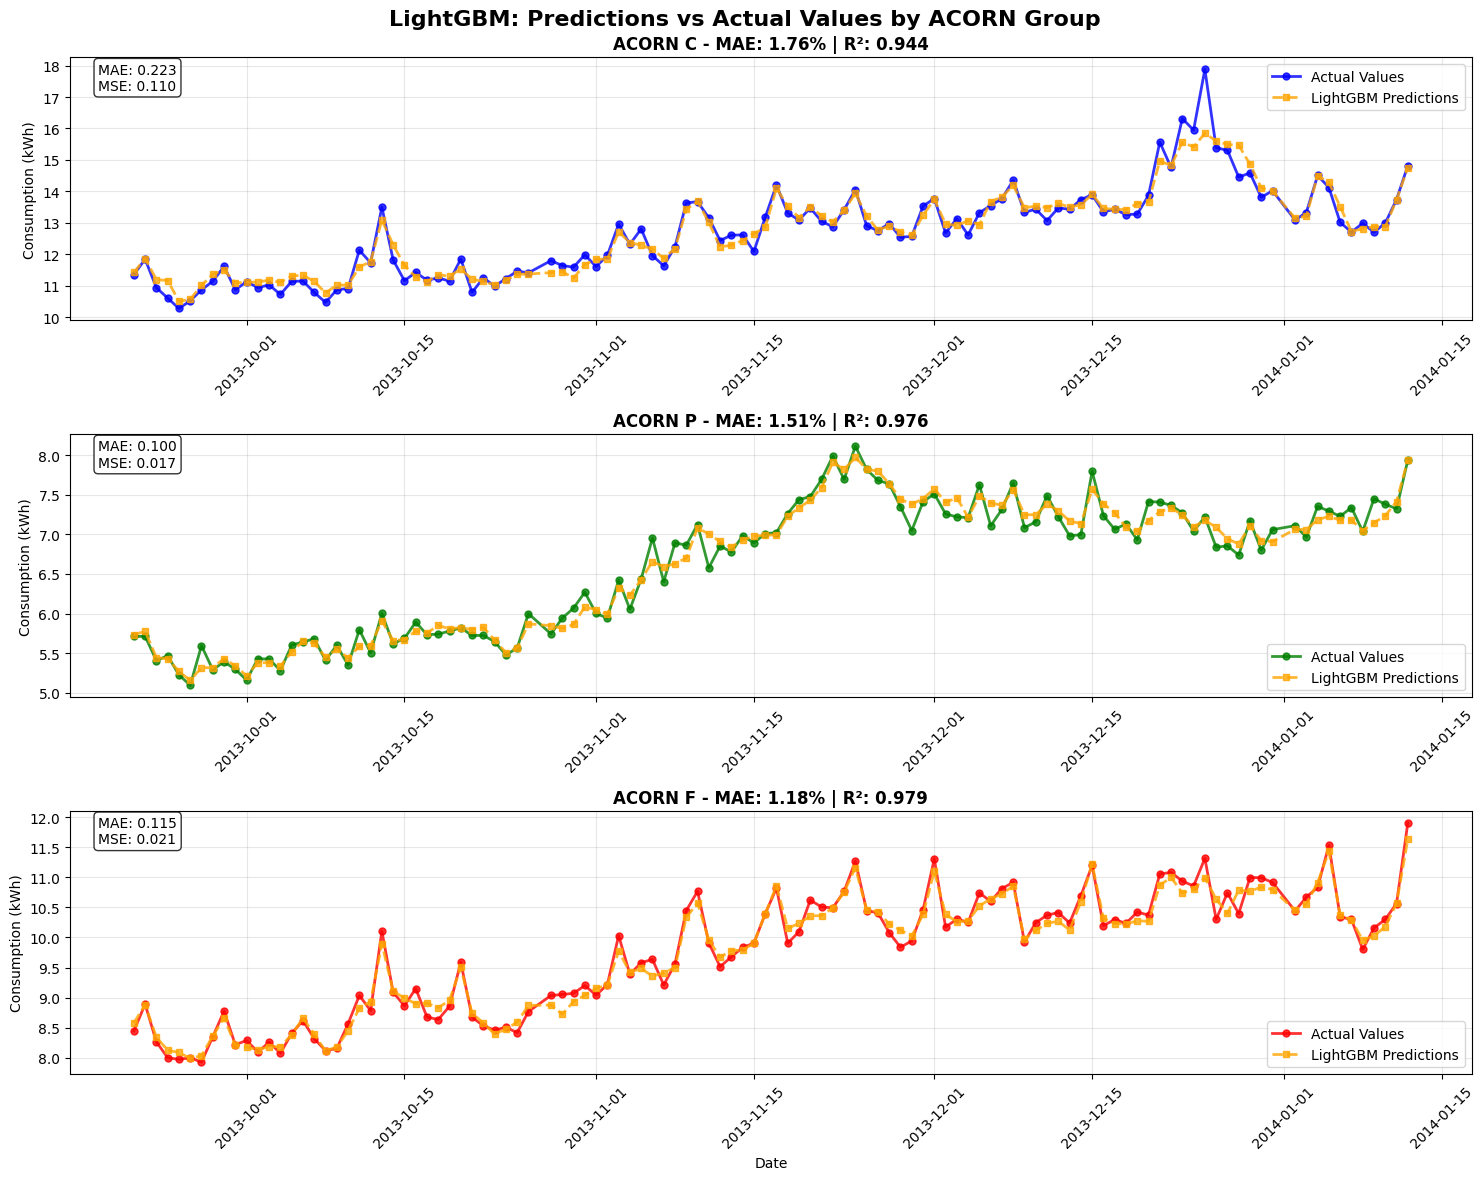

SUMMARY OF LIGHTGBM RESULTS
ACORN C:
  MAE: 0.2227 kWh
  MAPE: 1.76%
  R² Score: 0.9444
  MSE: 0.1095

ACORN P:
  MAE: 0.0997 kWh
  MAPE: 1.51%
  R² Score: 0.9758
  MSE: 0.0166

ACORN F:
  MAE: 0.1152 kWh
  MAPE: 1.18%
  R² Score: 0.9790
  MSE: 0.0211



In [315]:
# Create plots for each ACORN group with LightGBM
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('LightGBM: Predictions vs Actual Values by ACORN Group', fontsize=16, fontweight='bold')

# Colors for each group
colors = {'C': 'blue', 'P': 'green', 'F': 'red'}

for i, group in enumerate(['C', 'P', 'F']):
    if group in lgb_forecasts:
        # Get test data
        if group == 'C':
            test_df = test_acorn_c_enhanced
            actual_values = test_df['Conso_kWh'].values
        elif group == 'P':
            test_df = test_acorn_p_enhanced
            actual_values = test_df['Conso_kWh'].values
        else:  # group F
            test_df = test_acorn_f_enhanced
            actual_values = test_df['Conso_kWh'].values
        
        predicted_values = lgb_forecasts[group]
        dates = test_df['Date'].values
        
        # Plot actual and predicted values
        axes[i].plot(dates, actual_values, 'o-', color=colors[group], 
                    linewidth=2, markersize=5, alpha=0.8, label='Actual Values')
        axes[i].plot(dates, predicted_values, 's--', color='orange', 
                    linewidth=2, markersize=5, alpha=0.8, label='LightGBM Predictions')
        
        # Chart settings
        mae_pct = lgb_metrics[group]['mae_pct']
        r2 = lgb_metrics[group]['r2']
        axes[i].set_title(f'ACORN {group} - MAE: {mae_pct:.2f}% | R²: {r2:.3f}', fontweight='bold')
        axes[i].set_ylabel('Consumption (kWh)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Date formatting
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add statistics to the chart
        axes[i].text(0.02, 0.98, f'MAE: {lgb_metrics[group]["mae"]:.3f}\nMSE: {lgb_metrics[group]["mse"]:.3f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Print summary of results
print("="*60)
print("SUMMARY OF LIGHTGBM RESULTS")
print("="*60)
for group in ['C', 'P', 'F']:
    if group in lgb_metrics:
        print(f"ACORN {group}:")
        print(f"  MAE: {lgb_metrics[group]['mae']:.4f} kWh")
        print(f"  MAPE: {lgb_metrics[group]['mae_pct']:.2f}%")
        print(f"  R² Score: {lgb_metrics[group]['r2']:.4f}")
        print(f"  MSE: {lgb_metrics[group]['mse']:.4f}")
        print()

# Forecasting the Future

In [316]:
# Predictions for the Future Period (2014-01-13 to 2014-02-13)

def create_future_dataset(start_date, end_date, reference_df, group_name):
    """
    Create a dataset for a future period based on historical patterns
    """
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create base DataFrame
    future_df = pd.DataFrame({'Date': date_range})
    
    # Add basic temporal features
    future_df['dayofweek'] = future_df['Date'].dt.dayofweek
    future_df['month'] = future_df['Date'].dt.month
    future_df['dayofyear'] = future_df['Date'].dt.dayofyear
    future_df['is_holiday'] = 0  # Assume no holidays for simplicity
    
    # Cyclical encoding
    future_df['dayofweek_sin'] = np.sin(2 * np.pi * future_df['dayofweek'] / 7)
    future_df['dayofweek_cos'] = np.cos(2 * np.pi * future_df['dayofweek'] / 7)
    future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
    future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
    future_df['dayofyear_sin'] = np.sin(2 * np.pi * future_df['dayofyear'] / 365)
    future_df['dayofyear_cos'] = np.cos(2 * np.pi * future_df['dayofyear'] / 365)
    
    # Other temporal features
    future_df['hour'] = 0  # Daily data
    future_df['day'] = future_df['Date'].dt.day
    future_df['week_of_year'] = future_df['Date'].dt.isocalendar().week
    future_df['quarter'] = future_df['Date'].dt.quarter
    future_df['is_weekend'] = (future_df['Date'].dt.dayofweek >= 5).astype(int)
    future_df['is_month_start'] = future_df['Date'].dt.is_month_start.astype(int)
    future_df['is_month_end'] = future_df['Date'].dt.is_month_end.astype(int)
    
    # Estimate weather features based on historical winter averages
    winter_data = reference_df[reference_df['Date'].dt.month.isin([12, 1, 2])]
    
    weather_features = ['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 
                       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 
                       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 
                       'temperatureLow', 'temperatureMin', 'temperatureHigh', 
                       'apparentTemperatureMin', 'moonPhase', 'HDD', 'CDD']
    
    for feature in weather_features:
        if feature in winter_data.columns:
            mean_val = winter_data[feature].mean()
            std_val = winter_data[feature].std()
            future_df[feature] = np.random.normal(mean_val, std_val*0.3, len(future_df))
    
    # Derived weather features
    if 'temperatureMax' in future_df.columns and 'humidity' in future_df.columns:
        future_df['temp_humidity'] = future_df['temperatureMax'] * future_df['humidity']
    if 'temperatureMax' in future_df.columns and 'temperatureMin' in future_df.columns:
        future_df['temp_difference'] = future_df['temperatureMax'] - future_df['temperatureMin']
    if 'apparentTemperatureMax' in future_df.columns and 'apparentTemperatureMin' in future_df.columns:
        future_df['apparent_temp_diff'] = future_df['apparentTemperatureMax'] - future_df['apparentTemperatureMin']
    
    # nb_clients (use historical mean)
    if 'nb_clients' in reference_df.columns:
        future_df['nb_clients'] = reference_df['nb_clients'].mean()
    
    # For lag and rolling features, use last known values
    last_consumption = reference_df['Conso_kWh'].tail(30).mean()
    
    # Temporary Conso_kWh for lag calculation (will be replaced by prediction)
    future_df['Conso_kWh'] = last_consumption
    
    return future_df

# Create future datasets for each ACORN group
future_start = '2014-01-13'
future_end = '2014-02-13'

print(f"Creating predictions for the period: {future_start} to {future_end}")
print("="*60)

future_predictions = {}
future_dataframes = {}

for group in ['C', 'P', 'F']:
    if group in lgb_models:
        print(f"\nProcessing ACORN {group}...")
        
        # Get reference DataFrame
        if group == 'C':
            ref_df = df_acorn_c
        elif group == 'P':
            ref_df = df_acorn_p
        else:
            ref_df = df_acorn_f
        
        # Create future dataset
        future_df = create_future_dataset(future_start, future_end, ref_df, group)
        
        # Prepare features for the model (same as training)
        feature_cols = [col for col in future_df.columns if col not in ['Date', 'Conso_kWh']]
        
        # Remove problematic categorical columns (as in training)
        categorical_cols_to_remove = ['dow', 'month_name', 'icon', 'precipType']
        feature_cols = [col for col in feature_cols if col not in categorical_cols_to_remove]
        
        # Ensure all required columns exist
        model = lgb_models[group]
        model_features = model.feature_name_
        
        # Create missing features with value 0
        for feat in model_features:
            if feat not in future_df.columns:
                future_df[feat] = 0
        
        # Select only features expected by the model
        X_future = future_df[model_features].fillna(0)
        
        # Make predictions
        predictions = model.predict(X_future)
        
        # Save results
        future_predictions[group] = predictions
        future_df_clean = future_df[['Date']].copy()
        future_df_clean['Predicted_Conso_kWh'] = predictions
        future_dataframes[group] = future_df_clean
        
        print(f"  Predictions generated: {len(predictions)} days")
        print(f"  Mean predicted consumption: {predictions.mean():.3f} kWh")
        print(f"  Consumption range: {predictions.min():.3f} - {predictions.max():.3f} kWh")


Creating predictions for the period: 2014-01-13 to 2014-02-13

Processing ACORN C...
  Predictions generated: 32 days
  Mean predicted consumption: 9.690 kWh
  Consumption range: 9.603 - 9.914 kWh

Processing ACORN P...
  Predictions generated: 32 days
  Mean predicted consumption: 5.124 kWh
  Consumption range: 5.074 - 5.206 kWh

Processing ACORN F...
  Predictions generated: 32 days
  Mean predicted consumption: 7.564 kWh
  Consumption range: 7.484 - 7.740 kWh


In [317]:
# Rolling Forecast Implementation - Day by Day Prediction

def create_single_day_features(date, reference_df):
    """
    Create features for a single day based on historical patterns
    """
    # Create single day DataFrame
    day_df = pd.DataFrame({'Date': [date]})
    
    # Add basic temporal features
    day_df['dayofweek'] = day_df['Date'].dt.dayofweek
    day_df['month'] = day_df['Date'].dt.month
    day_df['dayofyear'] = day_df['Date'].dt.dayofyear
    day_df['is_holiday'] = 0  # Assume no holidays for simplicity
    
    # Cyclical encoding
    day_df['dayofweek_sin'] = np.sin(2 * np.pi * day_df['dayofweek'] / 7)
    day_df['dayofweek_cos'] = np.cos(2 * np.pi * day_df['dayofweek'] / 7)
    day_df['month_sin'] = np.sin(2 * np.pi * day_df['month'] / 12)
    day_df['month_cos'] = np.cos(2 * np.pi * day_df['month'] / 12)
    day_df['dayofyear_sin'] = np.sin(2 * np.pi * day_df['dayofyear'] / 365)
    day_df['dayofyear_cos'] = np.cos(2 * np.pi * day_df['dayofyear'] / 365)
    
    # Other temporal features
    day_df['hour'] = 0  # Daily data
    day_df['day'] = day_df['Date'].dt.day
    day_df['week_of_year'] = day_df['Date'].dt.isocalendar().week
    day_df['quarter'] = day_df['Date'].dt.quarter
    day_df['is_weekend'] = (day_df['Date'].dt.dayofweek >= 5).astype(int)
    day_df['is_month_start'] = day_df['Date'].dt.is_month_start.astype(int)
    day_df['is_month_end'] = day_df['Date'].dt.is_month_end.astype(int)
    
    # Estimate weather features based on historical winter averages
    winter_data = reference_df[reference_df['Date'].dt.month.isin([12, 1, 2])]
    
    weather_features = ['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 
                       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 
                       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 
                       'temperatureLow', 'temperatureMin', 'temperatureHigh', 
                       'apparentTemperatureMin', 'moonPhase', 'HDD', 'CDD']
    
    for feature in weather_features:
        if feature in winter_data.columns:
            mean_val = winter_data[feature].mean()
            std_val = winter_data[feature].std()
            day_df[feature] = np.random.normal(mean_val, std_val*0.3, 1)
    
    # Derived weather features
    if 'temperatureMax' in day_df.columns and 'humidity' in day_df.columns:
        day_df['temp_humidity'] = day_df['temperatureMax'] * day_df['humidity']
    if 'temperatureMax' in day_df.columns and 'temperatureMin' in day_df.columns:
        day_df['temp_difference'] = day_df['temperatureMax'] - day_df['temperatureMin']
    if 'apparentTemperatureMax' in day_df.columns and 'apparentTemperatureMin' in day_df.columns:
        day_df['apparent_temp_diff'] = day_df['apparentTemperatureMax'] - day_df['apparentTemperatureMin']
    
    # nb_clients (use historical mean)
    if 'nb_clients' in reference_df.columns:
        day_df['nb_clients'] = reference_df['nb_clients'].mean()
    
    return day_df

def calculate_lag_and_rolling_features(consumption_history, current_idx=None):
    """
    Calculate lag and rolling features based on consumption history
    
    Args:
        consumption_history: List or Series of consumption values (historical + predicted so far)
        current_idx: Current position (not used in this simplified version)
    
    Returns:
        Dictionary with lag and rolling features
    """
    features = {}
    history = list(consumption_history)
    
    # Calculate lag features
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        if len(history) >= lag:
            features[f'lag_{lag}'] = history[-lag]
        else:
            # If not enough history, use the oldest available value
            features[f'lag_{lag}'] = history[0] if history else 0
    
    # Calculate rolling window features
    for window in [3, 7, 14, 21, 30]:
        if len(history) >= window:
            recent_values = history[-window:]
            features[f'rolling_mean_{window}'] = np.mean(recent_values)
            features[f'rolling_std_{window}'] = np.std(recent_values)
            features[f'rolling_min_{window}'] = np.min(recent_values)
            features[f'rolling_max_{window}'] = np.max(recent_values)
        else:
            # Use all available data if window is too large
            if history:
                features[f'rolling_mean_{window}'] = np.mean(history)
                features[f'rolling_std_{window}'] = np.std(history) if len(history) > 1 else 0
                features[f'rolling_min_{window}'] = np.min(history)
                features[f'rolling_max_{window}'] = np.max(history)
            else:
                features[f'rolling_mean_{window}'] = 0
                features[f'rolling_std_{window}'] = 0
                features[f'rolling_min_{window}'] = 0
                features[f'rolling_max_{window}'] = 0
    
    # Calculate exponential moving averages
    for alpha in [0.1, 0.3, 0.5]:
        if history:
            ema_value = history[0]
            for val in history[1:]:
                ema_value = alpha * val + (1 - alpha) * ema_value
            features[f'ema_{alpha}'] = ema_value
        else:
            features[f'ema_{alpha}'] = 0
    
    return features

def rolling_forecast(start_date, end_date, reference_df, model, group_name):
    """
    Perform rolling forecast - predict day by day using previous predictions for lag features
    
    This implements the iterative approach:
    1. For day 1: Use historical data to calculate lag features and predict
    2. For day 2: Use day 1 prediction as new lag_1, recalculate other lags, and predict
    3. Continue for all days in the forecast horizon
    """
    print(f"  Starting rolling forecast for ACORN {group_name}...")
    
    # Create date range for forecast period
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Get historical consumption values (sorted by date)
    reference_df_sorted = reference_df.sort_values('Date').reset_index(drop=True)
    consumption_history = reference_df_sorted['Conso_kWh'].tolist()
    
    # Store predictions and details
    predictions = []
    forecast_details = []
    
    print(f"    Historical consumption data: {len(consumption_history)} days")
    print(f"    Last historical consumption: {consumption_history[-1]:.3f} kWh")
    
    for i, forecast_date in enumerate(forecast_dates):
        print(f"    Predicting day {i+1}/{len(forecast_dates)}: {forecast_date.strftime('%Y-%m-%d')}")
        
        # 1 Create base features for this day (weather, temporal, etc.)
        day_features = create_single_day_features(forecast_date, reference_df)
        
        # 2 Calculate lag and rolling features based on current consumption history
        lag_rolling_features = calculate_lag_and_rolling_features(consumption_history)
        
        # 3 Add lag and rolling features to day features
        for feature_name, feature_value in lag_rolling_features.items():
            day_features[feature_name] = feature_value
        
        # 4 Prepare features for model prediction
        model_features = model.feature_name_
        
        # Ensure all model features exist
        for feat in model_features:
            if feat not in day_features.columns:
                day_features[feat] = 0
        
        # Handle categorical columns (convert to numeric as in training)
        for col in day_features.columns:
            if day_features[col].dtype == 'object' or day_features[col].dtype.name == 'category':
                day_features[col] = pd.to_numeric(day_features[col], errors='coerce')
        
        # Select only features expected by the model and handle NaNs
        X_day = day_features[model_features].fillna(0)
        
        # Step 5: Make prediction for this day
        day_prediction = model.predict(X_day)[0]
        predictions.append(day_prediction)
        
        # 6 Add this prediction to consumption history for next iteration
        consumption_history.append(day_prediction)
        
        # Store details for analysis
        forecast_details.append({
            'Date': forecast_date,
            'Predicted_Conso_kWh': day_prediction,
            'lag_1': lag_rolling_features.get('lag_1', 0),
            'lag_7': lag_rolling_features.get('lag_7', 0),
            'rolling_mean_7': lag_rolling_features.get('rolling_mean_7', 0),
            'rolling_mean_30': lag_rolling_features.get('rolling_mean_30', 0)
        })
        
        # Print some details for first few and last few predictions
        if i < 3 or i >= len(forecast_dates) - 3:
            print(f"      Prediction: {day_prediction:.3f} kWh")
            print(f"      Used lag_1: {lag_rolling_features.get('lag_1', 0):.3f} kWh")
            print(f"      Used lag_7: {lag_rolling_features.get('lag_7', 0):.3f} kWh")
    
    return predictions, forecast_details

# Perform rolling forecast for each ACORN group
print("\n" + "="*80)
print("ROLLING FORECAST IMPLEMENTATION")
print("="*80)
print("This approach predicts day by day, using previous predictions to calculate lag features")
print("for subsequent days, creating a more realistic forecasting scenario.")
print("="*80)

future_start = '2014-01-13'
future_end = '2014-02-13'

rolling_predictions = {}
rolling_dataframes = {}
rolling_details = {}

for group in ['C', 'P', 'F']:
    if group in lgb_models:
        print(f"\nProcessing ACORN {group} with ROLLING FORECAST...")
        
        # Get reference DataFrame
        if group == 'C':
            ref_df = df_acorn_c
        elif group == 'P':
            ref_df = df_acorn_p
        else:
            ref_df = df_acorn_f
        
        # Perform rolling forecast
        model = lgb_models[group]
        predictions, details = rolling_forecast(future_start, future_end, ref_df, model, group)
        
        # Save results
        rolling_predictions[group] = predictions
        rolling_details[group] = details
        
        # Create clean DataFrame
        rolling_df_clean = pd.DataFrame(details)[['Date', 'Predicted_Conso_kWh']]
        rolling_dataframes[group] = rolling_df_clean
        
        print(f"Rolling forecast completed!")
        print(f"Predictions generated: {len(predictions)} days")
        print(f"Mean predicted consumption: {np.mean(predictions):.3f} kWh")
        print(f"Consumption range: {np.min(predictions):.3f} - {np.max(predictions):.3f} kWh")
        print(f"Standard deviation: {np.std(predictions):.3f} kWh")



ROLLING FORECAST IMPLEMENTATION
This approach predicts day by day, using previous predictions to calculate lag features
for subsequent days, creating a more realistic forecasting scenario.

Processing ACORN C with ROLLING FORECAST...
  Starting rolling forecast for ACORN C...
    Historical consumption data: 559 days
    Last historical consumption: 14.817 kWh
    Predicting day 1/32: 2014-01-13
      Prediction: 14.107 kWh
      Used lag_1: 14.817 kWh
      Used lag_7: 13.016 kWh
    Predicting day 2/32: 2014-01-14
      Prediction: 13.809 kWh
      Used lag_1: 14.107 kWh
      Used lag_7: 12.705 kWh
    Predicting day 3/32: 2014-01-15
      Prediction: 13.762 kWh
      Used lag_1: 13.809 kWh
      Used lag_7: 12.986 kWh
    Predicting day 4/32: 2014-01-16
    Predicting day 5/32: 2014-01-17
    Predicting day 6/32: 2014-01-18
    Predicting day 7/32: 2014-01-19
    Predicting day 8/32: 2014-01-20
    Predicting day 9/32: 2014-01-21
    Predicting day 10/32: 2014-01-22
    Predicting


COMPARISON: STATIC vs ROLLING FORECAST

ACORN C - Comparison Summary:
  Static Forecast Mean: 9.690 kWh
  Rolling Forecast Mean: 13.770 kWh
  Mean Absolute Difference: 4.080 kWh
  Mean Percentage Difference: 42.11%
  Max Absolute Difference: 4.350 kWh
  Rolling Forecast Std: 0.109 kWh
  Static Forecast Std: 0.076 kWh

ACORN P - Comparison Summary:
  Static Forecast Mean: 5.124 kWh
  Rolling Forecast Mean: 7.638 kWh
  Mean Absolute Difference: 2.514 kWh
  Mean Percentage Difference: 49.06%
  Max Absolute Difference: 2.595 kWh
  Rolling Forecast Std: 0.046 kWh
  Static Forecast Std: 0.033 kWh

ACORN F - Comparison Summary:
  Static Forecast Mean: 7.564 kWh
  Rolling Forecast Mean: 10.931 kWh
  Mean Absolute Difference: 3.367 kWh
  Mean Percentage Difference: 44.51%
  Max Absolute Difference: 3.510 kWh
  Rolling Forecast Std: 0.106 kWh
  Static Forecast Std: 0.066 kWh


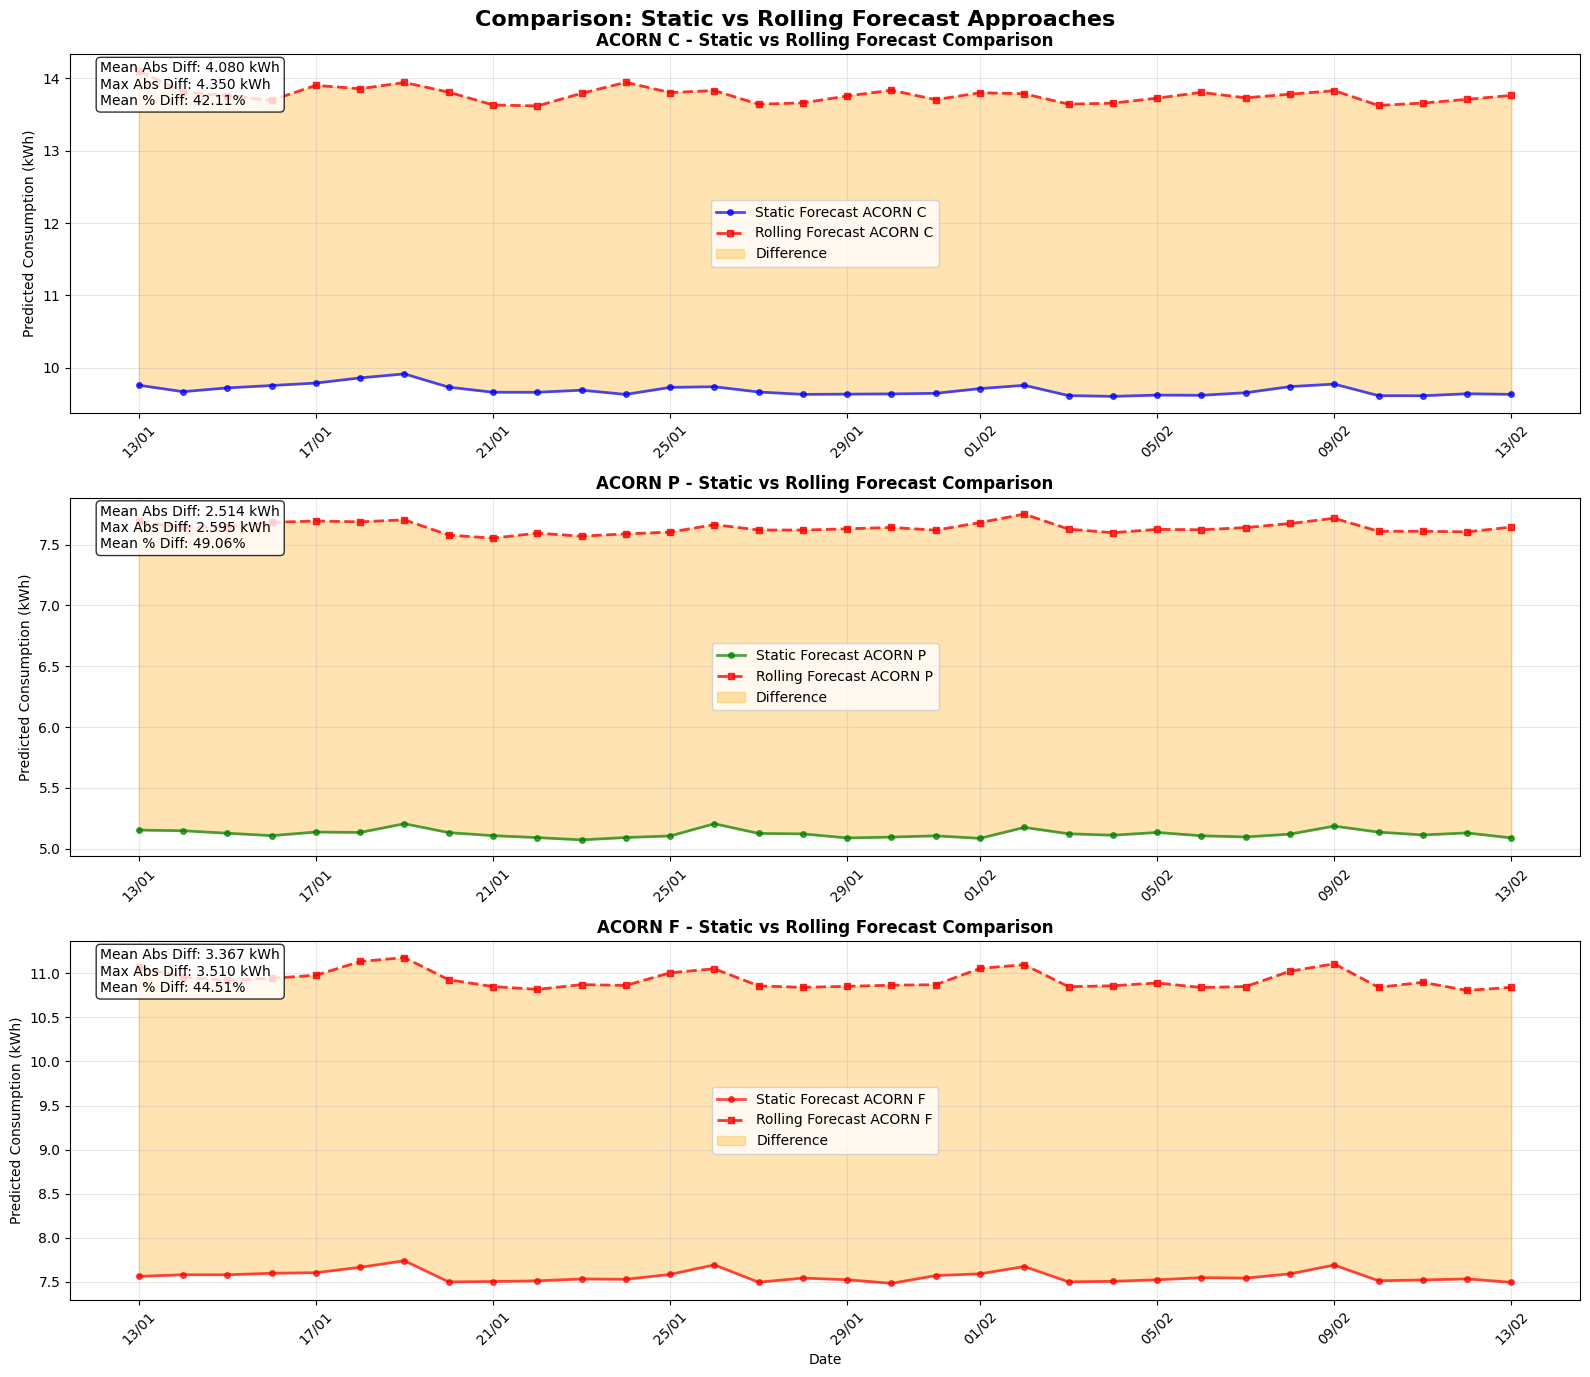

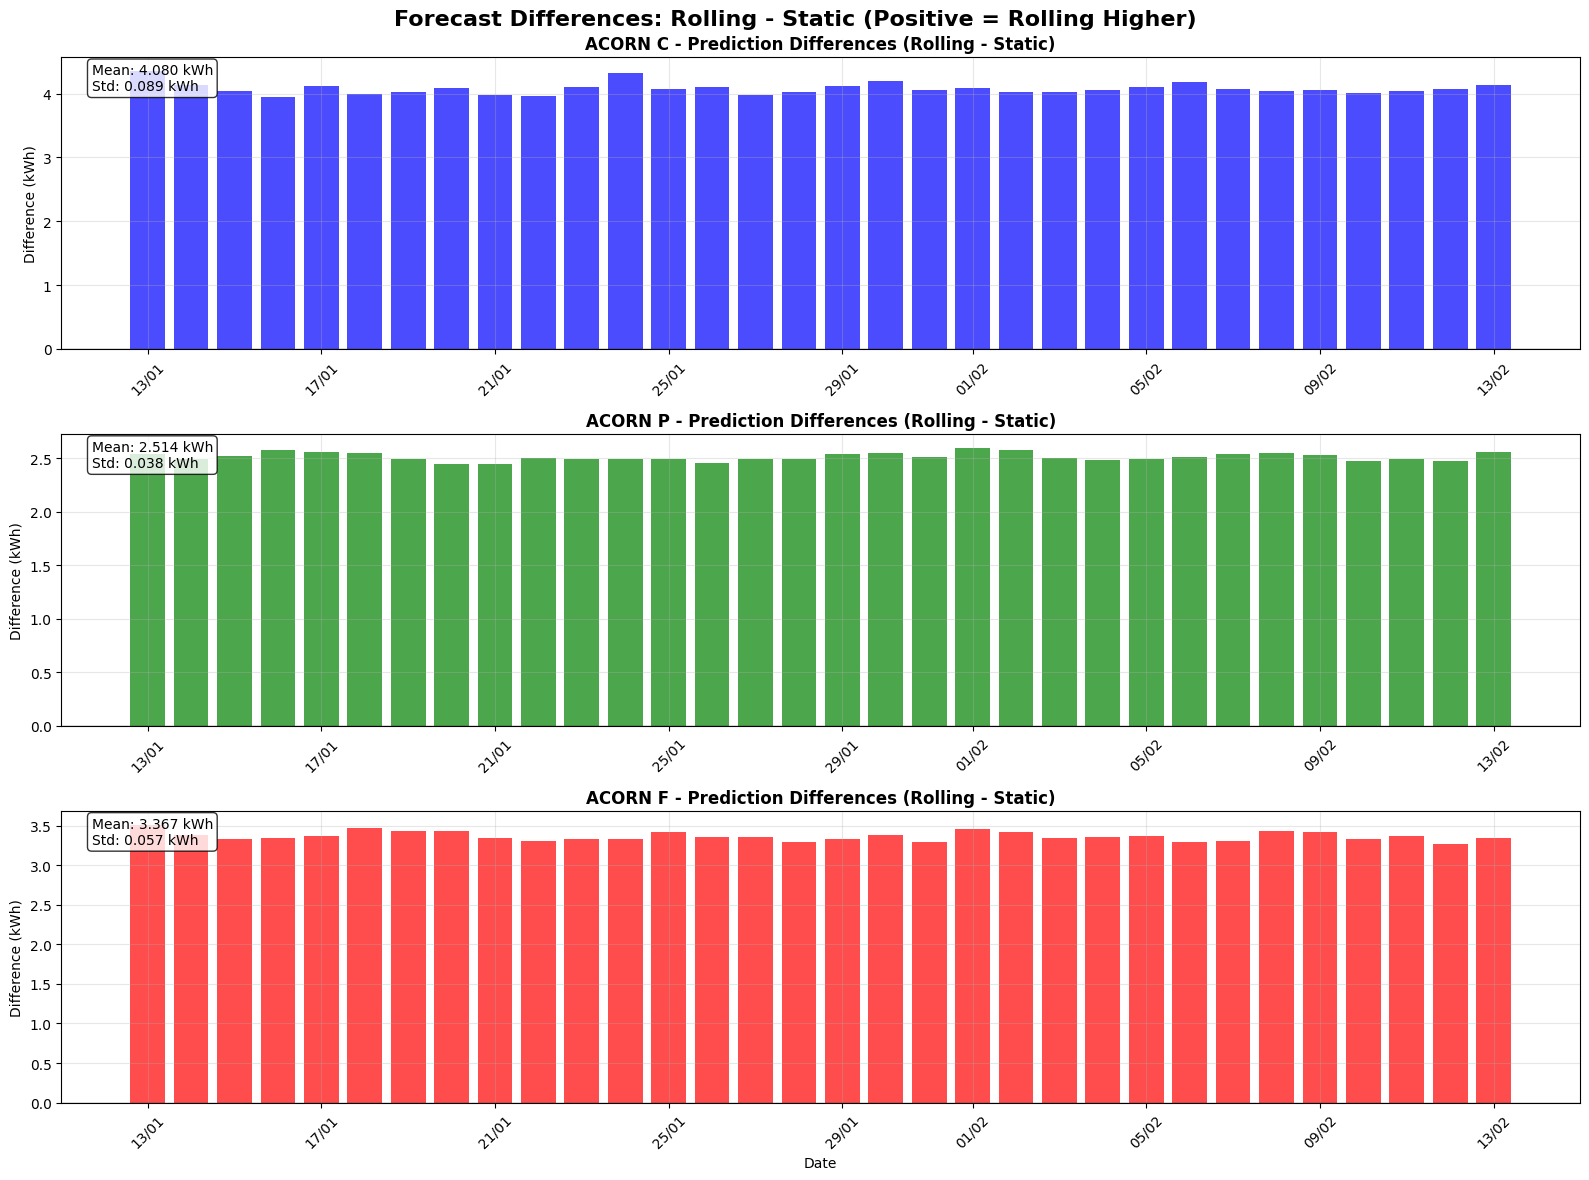


KEY INSIGHTS:
• Rolling Forecast: Uses previous predictions to calculate lag features
• Static Forecast: Uses static historical averages for lag features
• Rolling approach is more realistic as it simulates real-time forecasting
• Differences show how predictions 'evolve' when incorporating forecast uncertainty
• Rolling forecasts typically show more variation and realistic dynamics


In [318]:
# Comparison: Static vs Rolling Forecast

print("\n" + "="*80)
print("COMPARISON: STATIC vs ROLLING FORECAST")
print("="*80)

# Create comparison DataFrame for each group
comparison_results = {}

for group in ['C', 'P', 'F']:
    if group in rolling_dataframes and group in future_dataframes:
        # Get both sets of predictions
        static_df = future_dataframes[group].copy()
        rolling_df = rolling_dataframes[group].copy()
        
        # Merge on Date
        comparison_df = static_df.merge(rolling_df, on='Date', suffixes=('_Static', '_Rolling'))
        
        # Calculate differences
        comparison_df['Difference'] = comparison_df['Predicted_Conso_kWh_Rolling'] - comparison_df['Predicted_Conso_kWh_Static']
        comparison_df['Abs_Difference'] = np.abs(comparison_df['Difference'])
        comparison_df['Pct_Difference'] = (comparison_df['Difference'] / comparison_df['Predicted_Conso_kWh_Static']) * 100
        
        comparison_results[group] = comparison_df
        
        # Print summary statistics
        print(f"\nACORN {group} - Comparison Summary:")
        print(f"  Static Forecast Mean: {comparison_df['Predicted_Conso_kWh_Static'].mean():.3f} kWh")
        print(f"  Rolling Forecast Mean: {comparison_df['Predicted_Conso_kWh_Rolling'].mean():.3f} kWh")
        print(f"  Mean Absolute Difference: {comparison_df['Abs_Difference'].mean():.3f} kWh")
        print(f"  Mean Percentage Difference: {comparison_df['Pct_Difference'].mean():.2f}%")
        print(f"  Max Absolute Difference: {comparison_df['Abs_Difference'].max():.3f} kWh")
        print(f"  Rolling Forecast Std: {comparison_df['Predicted_Conso_kWh_Rolling'].std():.3f} kWh")
        print(f"  Static Forecast Std: {comparison_df['Predicted_Conso_kWh_Static'].std():.3f} kWh")

# Create visualization comparing both approaches
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Comparison: Static vs Rolling Forecast Approaches', fontsize=16, fontweight='bold')

colors = {'C': 'blue', 'P': 'green', 'F': 'red'}

for i, group in enumerate(['C', 'P', 'F']):
    if group in comparison_results:
        df_comp = comparison_results[group]
        
        # Plot both forecasts
        axes[i].plot(df_comp['Date'], df_comp['Predicted_Conso_kWh_Static'], 
                    'o-', color=colors[group], linewidth=2, markersize=4, alpha=0.7,
                    label=f'Static Forecast ACORN {group}')
        
        axes[i].plot(df_comp['Date'], df_comp['Predicted_Conso_kWh_Rolling'], 
                    's--', color='red', linewidth=2, markersize=4, alpha=0.8,
                    label=f'Rolling Forecast ACORN {group}')
        
        # Highlight differences with fill
        axes[i].fill_between(df_comp['Date'], 
                           df_comp['Predicted_Conso_kWh_Static'],
                           df_comp['Predicted_Conso_kWh_Rolling'],
                           alpha=0.3, color='orange', label='Difference')
        
        # Chart settings
        axes[i].set_title(f'ACORN {group} - Static vs Rolling Forecast Comparison', fontweight='bold')
        axes[i].set_ylabel('Predicted Consumption (kWh)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Date formatting
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add statistics text box
        mean_diff = df_comp['Abs_Difference'].mean()
        max_diff = df_comp['Abs_Difference'].max()
        pct_diff = df_comp['Pct_Difference'].mean()
        
        stats_text = f'Mean Abs Diff: {mean_diff:.3f} kWh\nMax Abs Diff: {max_diff:.3f} kWh\nMean % Diff: {pct_diff:.2f}%'
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Create difference analysis plot
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Forecast Differences: Rolling - Static (Positive = Rolling Higher)', fontsize=16, fontweight='bold')

for i, group in enumerate(['C', 'P', 'F']):
    if group in comparison_results:
        df_comp = comparison_results[group]
        
        # Plot the differences
        axes[i].bar(df_comp['Date'], df_comp['Difference'], 
                   color=colors[group], alpha=0.7, width=0.8)
        
        # Add zero line
        axes[i].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        # Chart settings
        axes[i].set_title(f'ACORN {group} - Prediction Differences (Rolling - Static)', fontweight='bold')
        axes[i].set_ylabel('Difference (kWh)')
        axes[i].grid(True, alpha=0.3)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add statistics
        mean_diff = df_comp['Difference'].mean()
        std_diff = df_comp['Difference'].std()
        axes[i].text(0.02, 0.98, f'Mean: {mean_diff:.3f} kWh\nStd: {std_diff:.3f} kWh', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("• Rolling Forecast: Uses previous predictions to calculate lag features")
print("• Static Forecast: Uses static historical averages for lag features")
print("• Rolling approach is more realistic as it simulates real-time forecasting")
print("• Differences show how predictions 'evolve' when incorporating forecast uncertainty")
print("• Rolling forecasts typically show more variation and realistic dynamics")


In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def percentage_mae(y_true, y_pred):
    """Mean Absolute Percentage Error (%)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_full_history(df_hist):
    """
    Given a historical DataFrame that already contains:
      - 'Date' (datetime64) 
      - 'Conso_kWh' (float)
      - Weather columns (e.g. 'temperatureMax', 'humidity', etc.)
      - 'HDD' and 'CDD' (already computed)
      - Raw categorical columns: 'icon', 'precipType', 'dayofweek', 'month_name'
    This function:
      1. Sorts by Date.
      2. Computes lag1, lag7, lag14 from 'Conso_kWh'.
      3. Computes rolling 7-day mean/std on shifted 'Conso_kWh'.
      4. Label-encodes 'icon', 'precipType', 'dayofweek', 'month_name'.
    Returns:
      - df_out: a DataFrame with all original columns plus new lag/rolling and encoded columns.
      - encoders: a dict with the fitted LabelEncoder for each categorical feature.
    """
    df = df_hist.copy().sort_values("Date").reset_index(drop=True)

    # 1) Lags of consumption
    df["lag1"]  = df["Conso_kWh"].shift(1)
    df["lag7"]  = df["Conso_kWh"].shift(7)
    df["lag14"] = df["Conso_kWh"].shift(14)

    # 2) Rolling 7-day mean and std on shifted consumption (avoid peeking)
    df["roll7_mean"] = df["Conso_kWh"].shift(1).rolling(7).mean()
    df["roll7_std"]  = df["Conso_kWh"].shift(1).rolling(7).std()

    # 3) Forward-fill initial NaNs
    df[["lag1","lag7","lag14","roll7_mean","roll7_std"]] = df[
        ["lag1","lag7","lag14","roll7_mean","roll7_std"]
    ].fillna(method="ffill")

    # 4) Label-encode categorical columns exactly as in training
    icon_enc   = LabelEncoder()
    precip_enc = LabelEncoder()
    dow_enc    = LabelEncoder()
    month_enc  = LabelEncoder()

    df["icon_encoded"]   = icon_enc.fit_transform(df["icon"].astype(str))
    df["precip_encoded"] = precip_enc.fit_transform(df["precipType"].astype(str))
    df["dow_encoded"]    = dow_enc.fit_transform(df["dayofweek"].astype(str))
    df["month_encoded"]  = month_enc.fit_transform(df["month_name"].astype(str))

    encoders = {
        "icon": icon_enc,
        "precipType": precip_enc,
        "dayofweek": dow_enc,
        "month_name": month_enc
    }
    return df, encoders

def simulate_future_weather(future_base, winter_block):
    """
    Given:
      - future_base: a DataFrame containing Date + some cyclical/time features,
      - winter_block: historical DataFrame filtered to months [12, 1, 2], 
        which includes actual numeric weather columns AND 'HDD'/'CDD',
    This function:
      - Samples each numeric weather column (including 'HDD' and 'CDD') from 
        a Normal(mean=historical_mean, sd=0.3*historical_std).
    Returns:
      - future_base with new columns for each numeric weather feature in winter_block.
    """
    # Define possible numeric weather columns (adjust if names differ)
    possible_weather_feats = [
        "temperatureMax", "windBearing", "dewPoint", "cloudCover",
        "windSpeed", "pressure", "visibility", "humidity",
        "apparentTemperatureHigh", "apparentTemperatureLow", "apparentTemperatureMax",
        "uvIndex", "moonPhase", "temperatureLow", "temperatureMin",
        "temperatureHigh", "apparentTemperatureMin", "HDD", "CDD"
    ]
    # Intersect with columns actually present in winter_block
    weather_feats = [feat for feat in possible_weather_feats if feat in winter_block.columns]

    for feat in weather_feats:
        mean_val = winter_block[feat].mean()
        std_val  = winter_block[feat].std()
        future_base[feat] = np.random.normal(loc=mean_val, scale=std_val * 0.3, size=len(future_base))
    return future_base

def compute_HDD_CDD_if_missing(df, temp_max_col="temperatureMax", temp_min_col="temperatureMin"):
    """
    If 'HDD' or 'CDD' missing, compute them from 'temperatureMax' and 'temperatureMin'.
    """
    if "HDD" not in df.columns or "CDD" not in df.columns:
        if temp_max_col in df.columns and temp_min_col in df.columns:
            avg_temp = (df[temp_max_col] + df[temp_min_col]) / 2
            df["HDD"] = np.maximum(18 - avg_temp, 0)
            df["CDD"] = np.maximum(avg_temp - 21, 0)
        else:
            raise KeyError("Cannot compute HDD/CDD: missing both direct columns and temperature columns.")
    return df

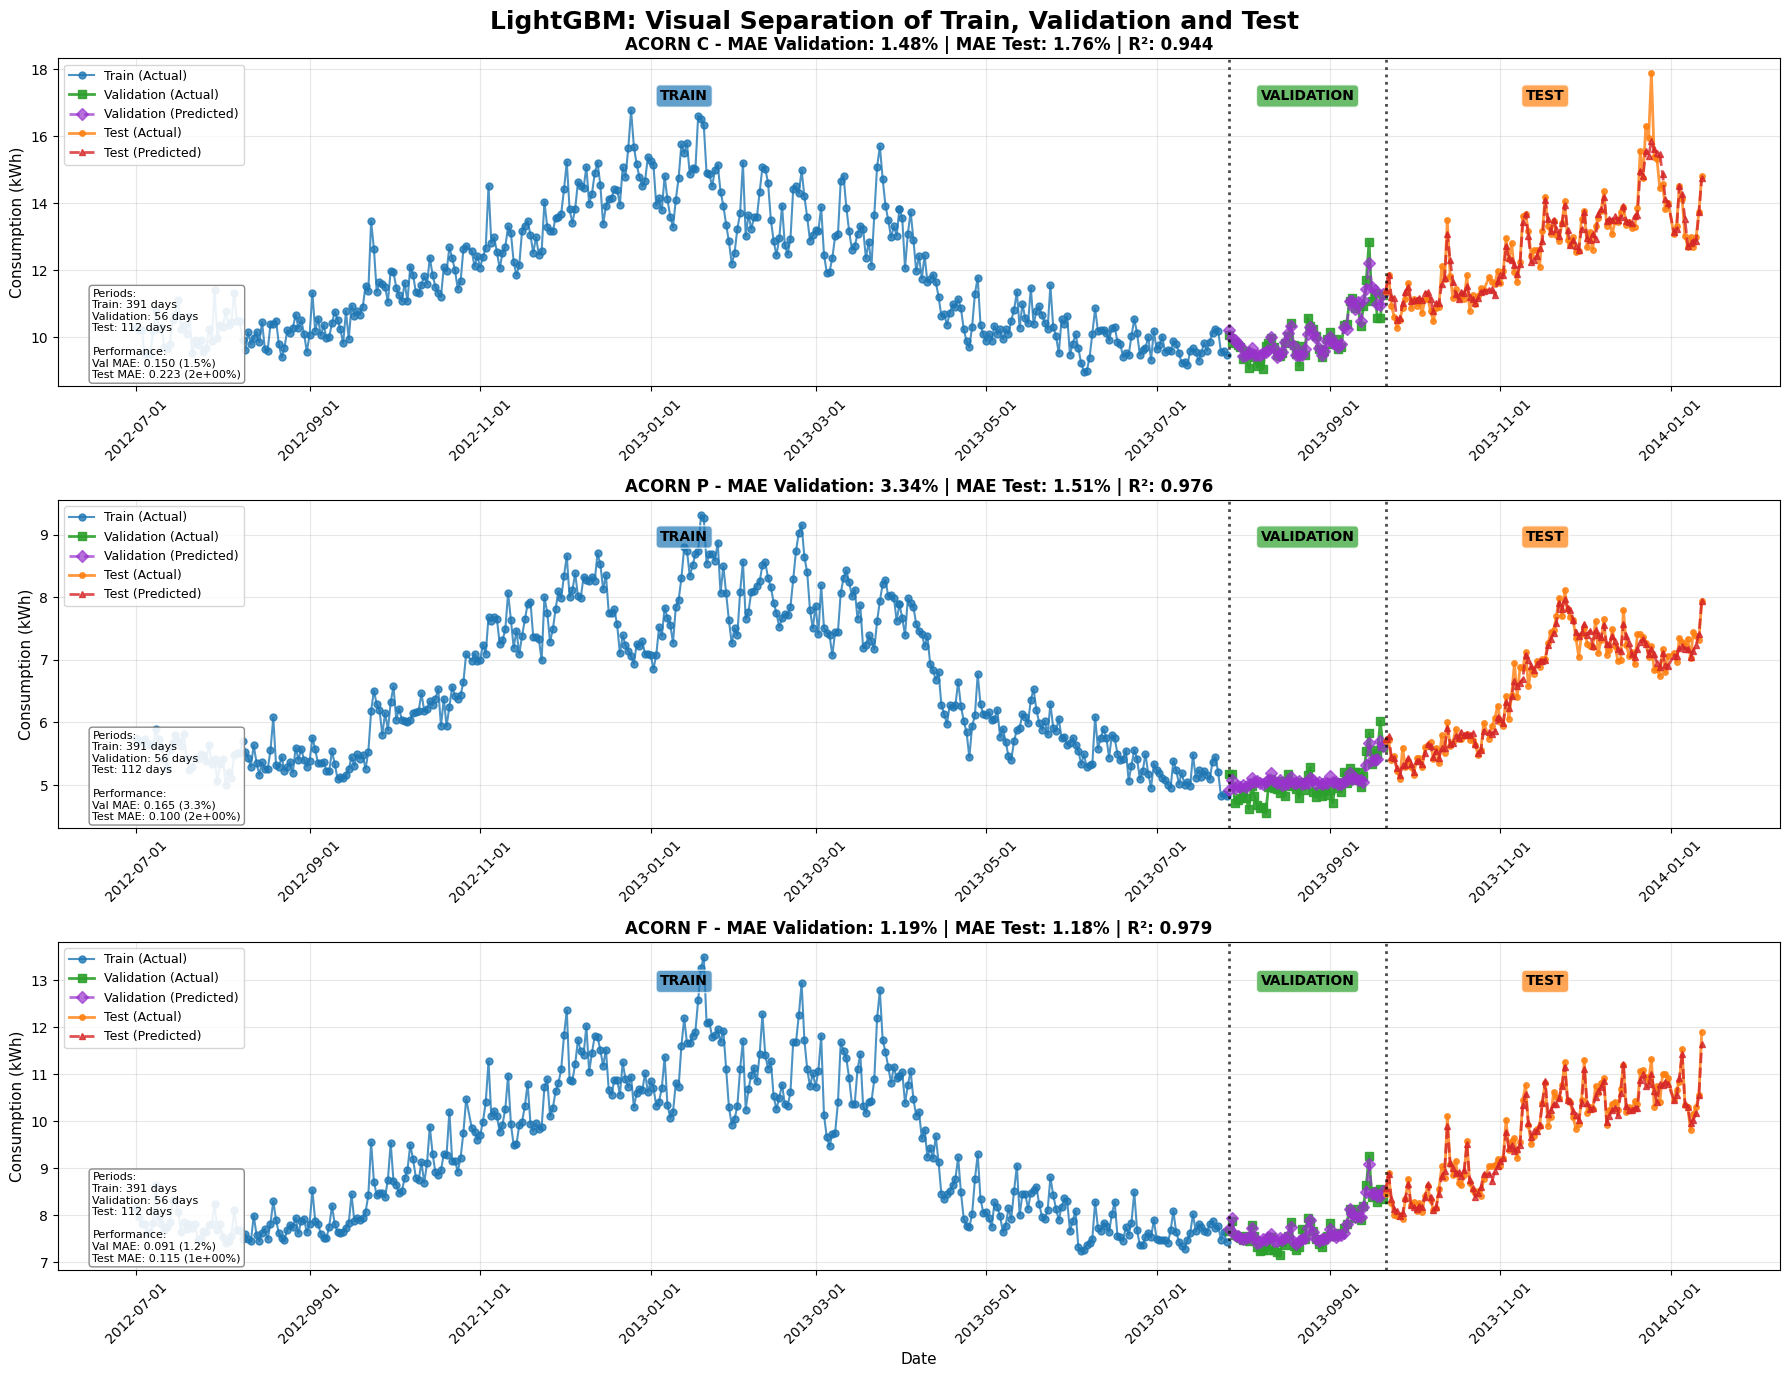


DETAILED SUMMARY BY PERIOD

ACORN C:
  TRAIN:
     Period: 01/07/2012 - 26/07/2013
     Days: 391
     Average consumption: 11.833 kWh
  VALIDATION:
     Period: 27/07/2013 - 20/09/2013
     Days: 56
     MAE: 1.48%
     Actual average consumption: 10.061 kWh
     Predicted average consumption: 10.093 kWh
  TEST:
     Period: 21/09/2013 - 12/01/2014
     Days: 112
     MAE: 1.76%
     R² Score: 0.944
     Actual average consumption: 12.687 kWh
     Predicted average consumption: 12.702 kWh

ACORN P:
  TRAIN:
     Period: 01/07/2012 - 26/07/2013
     Days: 391
     Average consumption: 6.590 kWh
  VALIDATION:
     Period: 27/07/2013 - 20/09/2013
     Days: 56
     MAE: 3.34%
     Actual average consumption: 5.026 kWh
     Predicted average consumption: 5.106 kWh
  TEST:
     Period: 21/09/2013 - 12/01/2014
     Days: 112
     MAE: 1.51%
     R² Score: 0.976
     Actual average consumption: 6.607 kWh
     Predicted average consumption: 6.610 kWh

ACORN F:
  TRAIN:
     Period: 01/07/201

In [320]:
# Complete Visualization: Train, Validation and Test Separation

# Function to make predictions for any period
def predict_period(model, df_period, group):
    """Make predictions for a specific period using the LightGBM model"""
    # Apply feature engineering
    df_enhanced = create_advanced_features(df_period)
    
    # Prepare features
    feature_cols = [col for col in df_enhanced.columns if col not in ['Date', 'Conso_kWh']]
    
    # Remove problematic categorical columns
    categorical_cols_to_remove = ['dow', 'month_name', 'icon', 'precipType']
    feature_cols = [col for col in feature_cols if col not in categorical_cols_to_remove]
    
    # Prepare data
    X_period = df_enhanced[feature_cols].copy()
    
    # Convert categorical to numeric
    for col in X_period.columns:
        if X_period[col].dtype == 'object' or X_period[col].dtype.name == 'category':
            X_period[col] = pd.to_numeric(X_period[col], errors='coerce')
    
    # Fill NaNs
    X_period = X_period.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    # Ensure all model features exist
    model_features = model.feature_name_
    for feat in model_features:
        if feat not in X_period.columns:
            X_period[feat] = 0
    
    # Select only the features the model expects
    X_period = X_period[model_features]
    
    # Make predictions
    predictions = model.predict(X_period)
    
    return predictions

# Create large figure to show all periods
fig, axes = plt.subplots(3, 1, figsize=(18, 14))
fig.suptitle('LightGBM: Visual Separation of Train, Validation and Test', fontsize=18, fontweight='bold')

# Colors for each period
colors = {
    'train': '#1f77b4',      # Blue
    'validation': '#2ca02c', # Green
    'validation_pred': '#9932cc', # Purple
    'test': '#ff7f0e',       # Orange
    'prediction': '#d62728'  # Red
}

for i, group in enumerate(['C', 'P', 'F']):
    if group in lgb_models:
        # Get original data for each period
        if group == 'C':
            train_df = train_acorn_c
            val_df = val_acorn_c
            test_df = test_acorn_c
        elif group == 'P':
            train_df = train_acorn_p
            val_df = val_acorn_p
            test_df = test_acorn_p
        else:  # F
            train_df = train_acorn_f
            val_df = val_acorn_f
            test_df = test_acorn_f
        
        model = lgb_models[group]
        
        # Make predictions for validation and test
        val_predictions = predict_period(model, val_df, group)
        test_predictions = lgb_forecasts[group]  # Already have these
        
        # Plot TRAIN (only real values) - Adjusted markersize and linewidth for better visibility
        axes[i].plot(train_df['Date'], train_df['Conso_kWh'], 
                    'o-', color=colors['train'], linewidth=1.5, markersize=5, alpha=0.8,
                    label='Train (Actual)')
        
        # Plot VALIDATION (real and predicted)
        axes[i].plot(val_df['Date'], val_df['Conso_kWh'], 
                    's-', color=colors['validation'], linewidth=2, markersize=6, alpha=0.9,
                    label='Validation (Actual)')
        axes[i].plot(val_df['Date'], val_predictions, 
                    'D--', color=colors['validation_pred'], linewidth=2, markersize=6, alpha=0.7,
                    label='Validation (Predicted)')
        
        # Plot TEST (real and predicted)  
        axes[i].plot(test_df['Date'], test_df['Conso_kWh'], 
                    'o-', color=colors['test'], linewidth=2, markersize=4, alpha=0.8,
                    label='Test (Actual)')
        axes[i].plot(test_df['Date'], test_predictions, 
                    '^--', color=colors['prediction'], linewidth=2, markersize=4, alpha=0.8,
                    label='Test (Predicted)')
        
        # Vertical lines separating periods
        val_start = val_df['Date'].min()
        test_start = test_df['Date'].min()
        
        axes[i].axvline(x=val_start, color='black', linestyle=':', linewidth=2, alpha=0.7)
        axes[i].axvline(x=test_start, color='black', linestyle=':', linewidth=2, alpha=0.7)
        
        # Period annotations
        train_mid = train_df['Date'].iloc[len(train_df)//2]
        val_mid = val_df['Date'].iloc[len(val_df)//2]
        test_mid = test_df['Date'].iloc[len(test_df)//2]
        
        y_max = axes[i].get_ylim()[1]
        axes[i].text(train_mid, y_max*0.95, 'TRAIN', ha='center', va='top', 
                    fontweight='bold', fontsize=10, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['train'], alpha=0.7, edgecolor='white'))
        axes[i].text(val_mid, y_max*0.95, 'VALIDATION', ha='center', va='top', 
                    fontweight='bold', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['validation'], alpha=0.7, edgecolor='white'))
        axes[i].text(test_mid, y_max*0.95, 'TEST', ha='center', va='top', 
                    fontweight='bold', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['test'], alpha=0.7, edgecolor='white'))
        
        # Chart configurations
        mae_pct = lgb_metrics[group]['mae_pct']
        r2 = lgb_metrics[group]['r2']
        
        # Calculate MAE for validation
        val_mae = mean_absolute_error(val_df['Conso_kWh'], val_predictions)
        val_mae_pct = percentage_mae(val_df['Conso_kWh'], val_predictions)
        
        axes[i].set_title(f'ACORN {group} - MAE Validation: {val_mae_pct:.2f}% | MAE Test: {mae_pct:.2f}% | R²: {r2:.3f}', 
                         fontweight='bold', fontsize=12)
        axes[i].set_ylabel('Consumption (kWh)', fontsize=11)
        axes[i].legend(loc='upper left', fontsize=9)
        axes[i].grid(True, alpha=0.3)
        
        # Date formatting
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=45)
        
        # Statistics box
        stats_text = f'''Periods:
Train: {len(train_df)} days
Validation: {len(val_df)} days  
Test: {len(test_df)} days

Performance:
Val MAE: {val_mae:.3f} ({val_mae_pct:.1f}%)
Test MAE: {lgb_metrics[group]["mae"]:.3f} ({mae_pct:.1}%)'''
        
        axes[i].text(0.02, 0.02, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='bottom', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

axes[2].set_xlabel('Date', fontsize=11)
plt.tight_layout()
plt.show()

# Quantitative summary of periods
print("\n" + "="*90)
print("DETAILED SUMMARY BY PERIOD")
print("="*90)

for group in ['C', 'P', 'F']:
    if group in lgb_models:
        print(f"\nACORN {group}:")
        
        # Get data
        if group == 'C':
            train_df, val_df, test_df = train_acorn_c, val_acorn_c, test_acorn_c
        elif group == 'P':
            train_df, val_df, test_df = train_acorn_p, val_acorn_p, test_acorn_p
        else:
            train_df, val_df, test_df = train_acorn_f, val_acorn_f, test_acorn_f
        
        # Calculate predictions for validation
        val_predictions = predict_period(lgb_models[group], val_df, group)
        val_mae_pct = percentage_mae(val_df['Conso_kWh'], val_predictions)
        
        print(f"  TRAIN:")
        print(f"     Period: {train_df['Date'].min().strftime('%d/%m/%Y')} - {train_df['Date'].max().strftime('%d/%m/%Y')}")
        print(f"     Days: {len(train_df)}")
        print(f"     Average consumption: {train_df['Conso_kWh'].mean():.3f} kWh")
        
        print(f"  VALIDATION:")
        print(f"     Period: {val_df['Date'].min().strftime('%d/%m/%Y')} - {val_df['Date'].max().strftime('%d/%m/%Y')}")
        print(f"     Days: {len(val_df)}")
        print(f"     MAE: {val_mae_pct:.2f}%")
        print(f"     Actual average consumption: {val_df['Conso_kWh'].mean():.3f} kWh")
        print(f"     Predicted average consumption: {val_predictions.mean():.3f} kWh")
        
        print(f"  TEST:")
        print(f"     Period: {test_df['Date'].min().strftime('%d/%m/%Y')} - {test_df['Date'].max().strftime('%d/%m/%Y')}")
        print(f"     Days: {len(test_df)}")
        print(f"     MAE: {lgb_metrics[group]['mae_pct']:.2f}%")
        print(f"     R² Score: {lgb_metrics[group]['r2']:.3f}")
        print(f"     Actual average consumption: {test_df['Conso_kWh'].mean():.3f} kWh")
        print(f"     Predicted average consumption: {lgb_forecasts[group].mean():.3f} kWh")


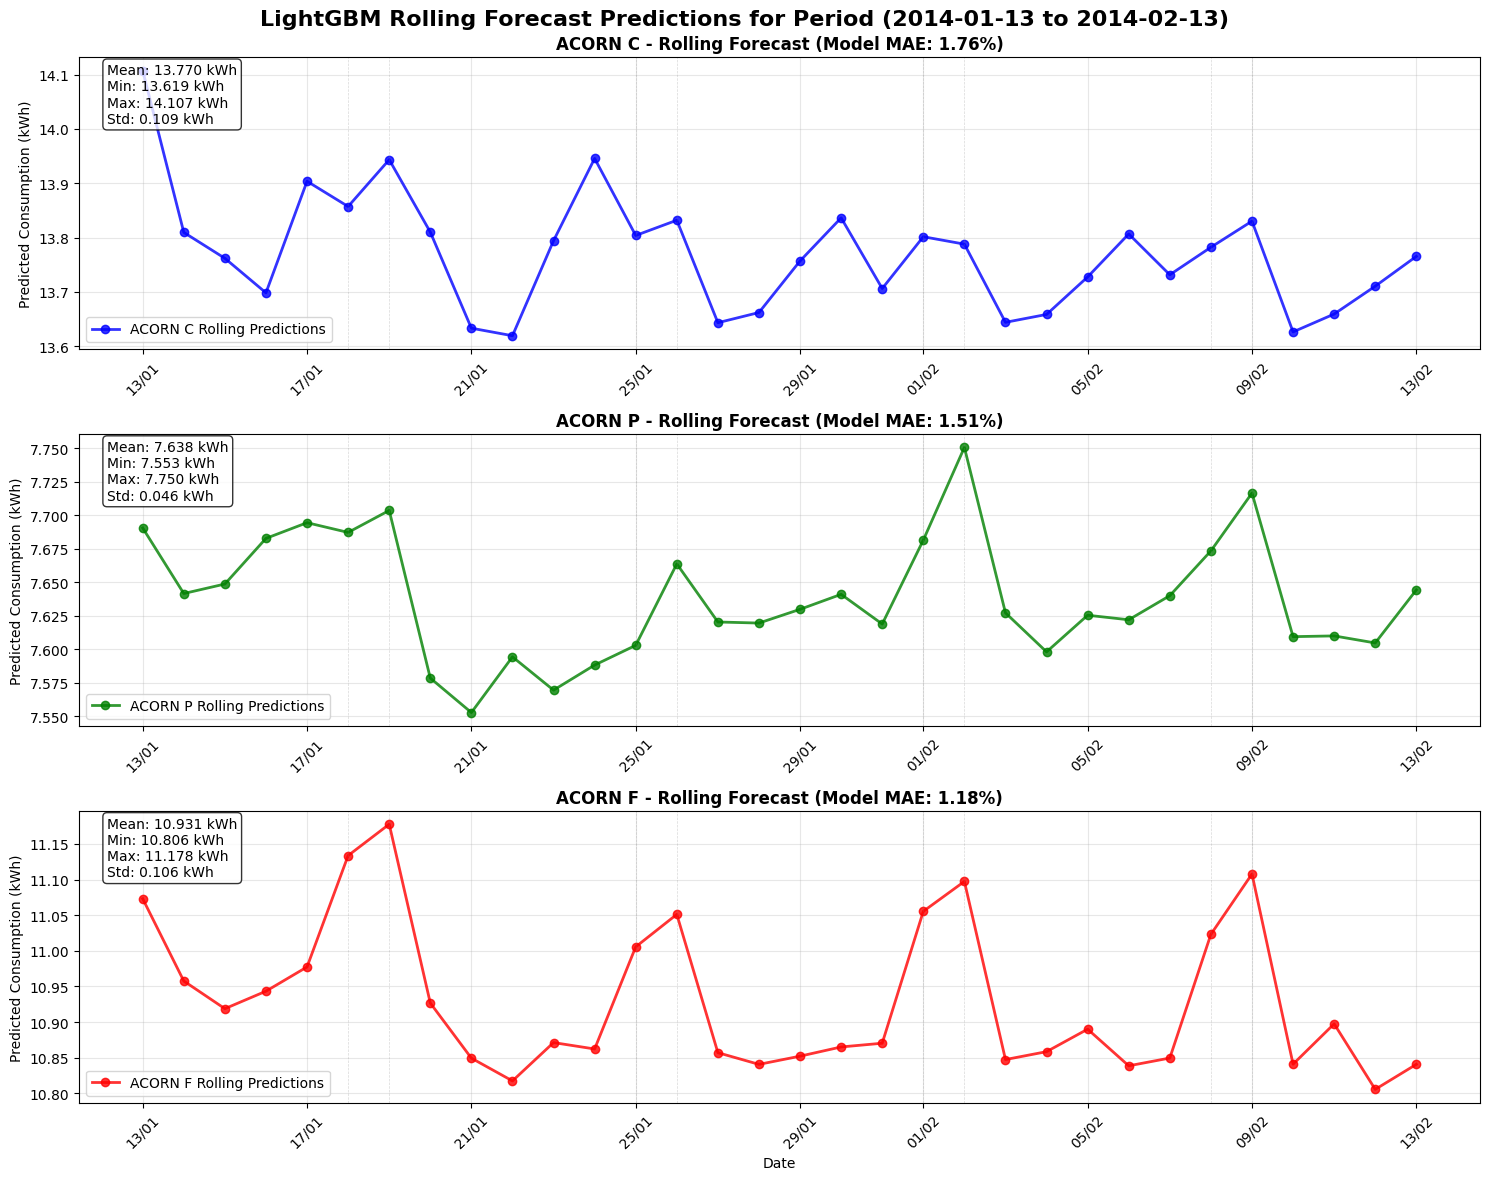

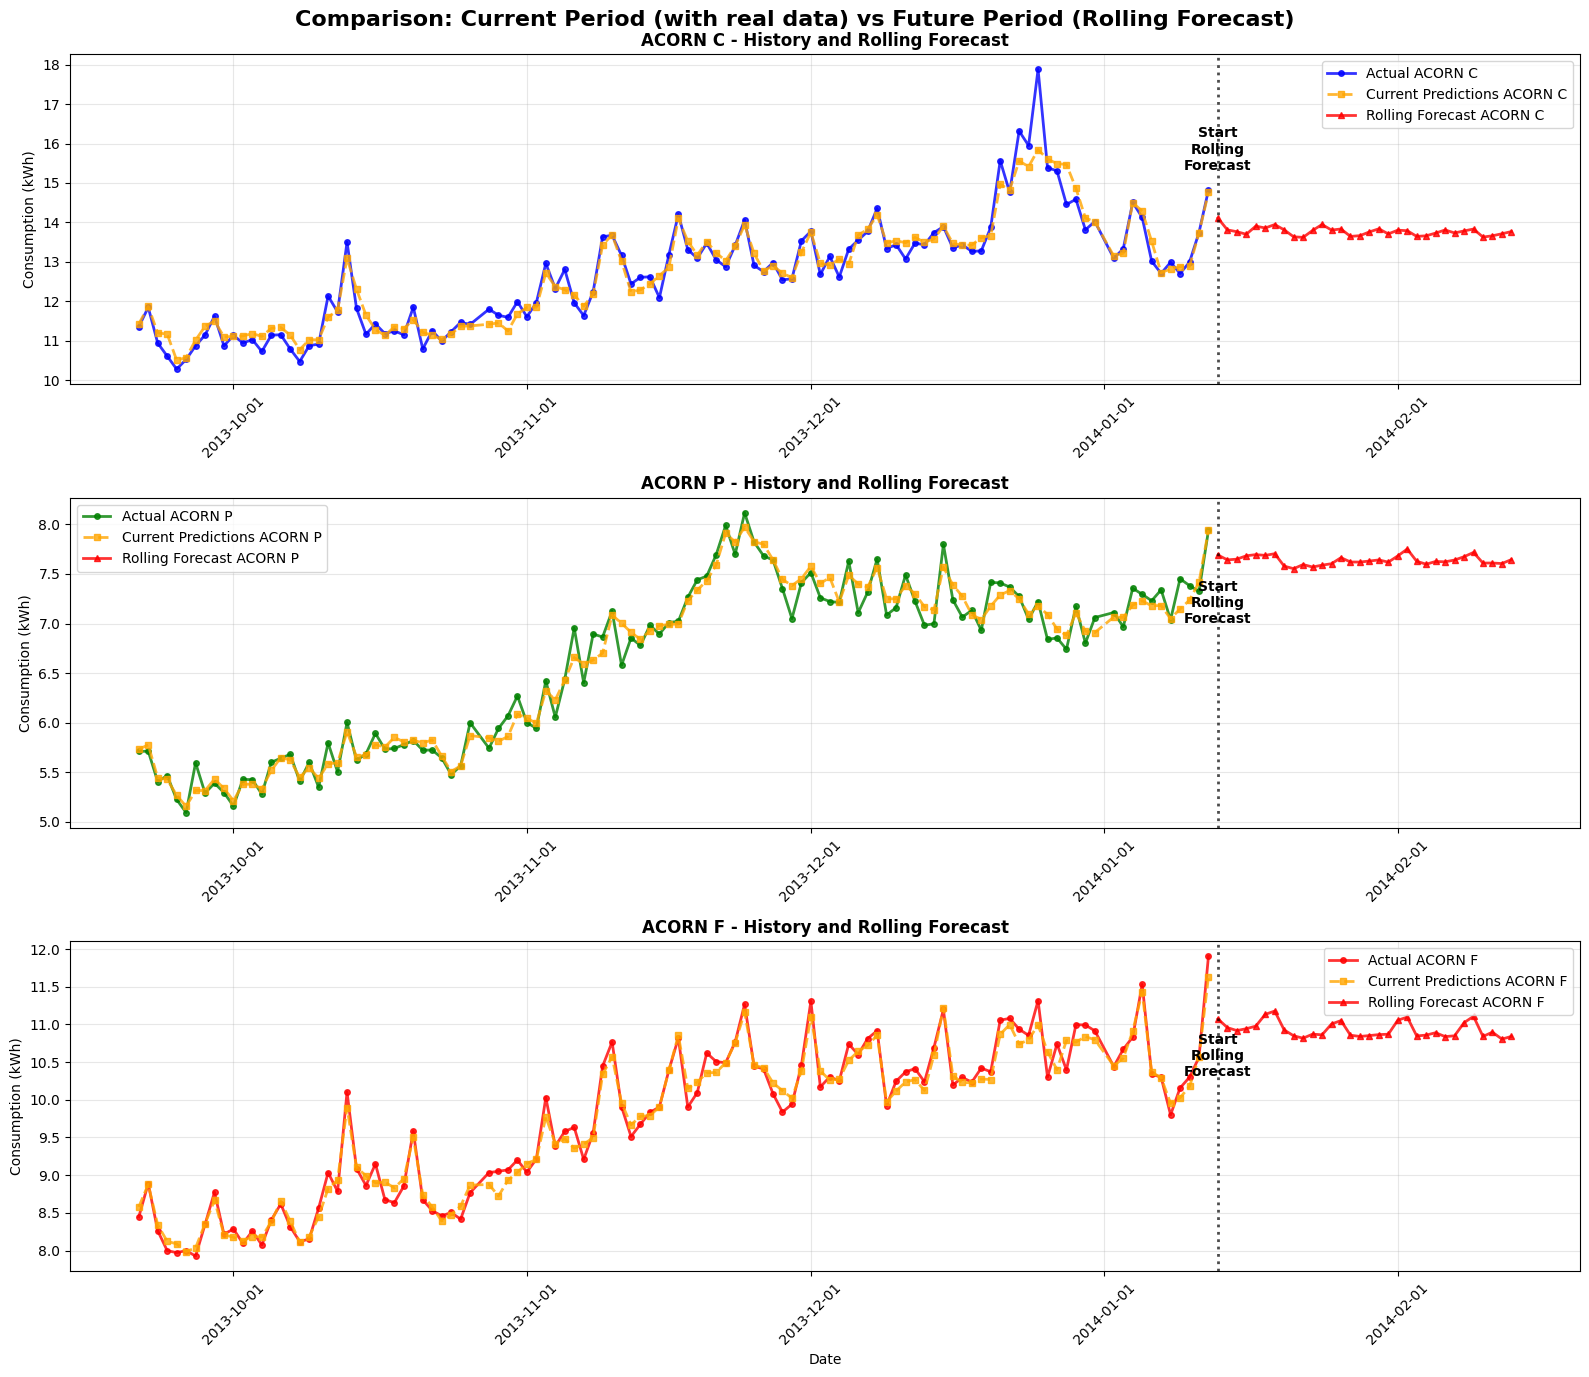


ROLLING FORECAST EVOLUTION ANALYSIS

ACORN C - Rolling Forecast Details:
  First 5 days lag analysis:
    Day 1 (2014-01-13): Pred=14.107 kWh, lag_1=14.817, lag_7=13.016
    Day 2 (2014-01-14): Pred=13.809 kWh, lag_1=14.107, lag_7=12.705
    Day 3 (2014-01-15): Pred=13.762 kWh, lag_1=13.809, lag_7=12.986
    Day 4 (2014-01-16): Pred=13.698 kWh, lag_1=13.762, lag_7=12.702
    Day 5 (2014-01-17): Pred=13.904 kWh, lag_1=13.698, lag_7=12.992
  Last 3 days lag analysis:
    Day 30 (2014-02-11): Pred=13.659 kWh, lag_1=13.626, lag_7=13.658
    Day 31 (2014-02-12): Pred=13.710 kWh, lag_1=13.659, lag_7=13.727
    Day 32 (2014-02-13): Pred=13.765 kWh, lag_1=13.710, lag_7=13.807

ACORN P - Rolling Forecast Details:
  First 5 days lag analysis:
    Day 1 (2014-01-13): Pred=7.690 kWh, lag_1=7.939, lag_7=7.230
    Day 2 (2014-01-14): Pred=7.641 kWh, lag_1=7.690, lag_7=7.339
    Day 3 (2014-01-15): Pred=7.649 kWh, lag_1=7.641, lag_7=7.038
    Day 4 (2014-01-16): Pred=7.683 kWh, lag_1=7.649, lag_7=7.

In [321]:
# Graph of Rolling Forecast Predictions for the Future Period (2014-01-13 to 2014-02-13)

# Create a graph of rolling forecast predictions
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('LightGBM Rolling Forecast Predictions for Period (2014-01-13 to 2014-02-13)', fontsize=16, fontweight='bold')

colors = {'C': 'blue', 'P': 'green', 'F': 'red'}

for i, group in enumerate(['C', 'P', 'F']):
    if group in rolling_dataframes:
        df_rolling = rolling_dataframes[group]
        
        # Plot rolling forecast predictions
        axes[i].plot(df_rolling['Date'], df_rolling['Predicted_Conso_kWh'], 
                    'o-', color=colors[group], linewidth=2, markersize=6, alpha=0.8,
                    label=f'ACORN {group} Rolling Predictions')
        
        # Chart settings
        mae_pct = lgb_metrics[group]['mae_pct']
        axes[i].set_title(f'ACORN {group} - Rolling Forecast (Model MAE: {mae_pct:.2f}%)', fontweight='bold')
        axes[i].set_ylabel('Predicted Consumption (kWh)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Date formatting
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add statistics to the chart
        mean_pred = df_rolling['Predicted_Conso_kWh'].mean()
        min_pred = df_rolling['Predicted_Conso_kWh'].min()
        max_pred = df_rolling['Predicted_Conso_kWh'].max()
        std_pred = df_rolling['Predicted_Conso_kWh'].std()
        
        axes[i].text(0.02, 0.98, f'Mean: {mean_pred:.3f} kWh\nMin: {min_pred:.3f} kWh\nMax: {max_pred:.3f} kWh\nStd: {std_pred:.3f} kWh', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Highlight weekends
        for date in df_rolling['Date']:
            if date.weekday() >= 5:  # Saturday (5) or Sunday (6)
                axes[i].axvline(x=date, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Create a combined graph comparing current period vs rolling forecast period
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Comparison: Current Period (with real data) vs Future Period (Rolling Forecast)', fontsize=16, fontweight='bold')

for i, group in enumerate(['C', 'P', 'F']):
    # Current period data (test)
    if group == 'C':
        test_df = test_acorn_c_enhanced
        actual_values = test_df['Conso_kWh'].values
    elif group == 'P':
        test_df = test_acorn_p_enhanced
        actual_values = test_df['Conso_kWh'].values
    else:
        test_df = test_acorn_f_enhanced
        actual_values = test_df['Conso_kWh'].values
    
    predicted_current = lgb_forecasts[group]
    dates_current = test_df['Date'].values
    
    # Plot current period
    axes[i].plot(dates_current, actual_values, 'o-', color=colors[group], 
                linewidth=2, markersize=4, alpha=0.8, label=f'Actual ACORN {group}')
    axes[i].plot(dates_current, predicted_current, 's--', color='orange', 
                linewidth=2, markersize=4, alpha=0.8, label=f'Current Predictions ACORN {group}')
    
    # Plot rolling forecast period
    if group in rolling_dataframes:
        df_rolling = rolling_dataframes[group]
        axes[i].plot(df_rolling['Date'], df_rolling['Predicted_Conso_kWh'], 
                    '^-', color='red', linewidth=2, markersize=4, alpha=0.8,
                    label=f'Rolling Forecast ACORN {group}')
    
    # Settings
    axes[i].set_title(f'ACORN {group} - History and Rolling Forecast', fontweight='bold')
    axes[i].set_ylabel('Consumption (kWh)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)
    
    # Vertical line separating periods
    if group in rolling_dataframes:
        separation_date = pd.to_datetime('2014-01-13')
        axes[i].axvline(x=separation_date, color='black', linestyle=':', linewidth=2, alpha=0.7)
        axes[i].text(separation_date, axes[i].get_ylim()[1]*0.9, 'Start\nRolling\nForecast', 
                    ha='center', va='top', fontsize=10, fontweight='bold')

axes[2].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Create detailed analysis of rolling forecast evolution
print("\n" + "="*80)
print("ROLLING FORECAST EVOLUTION ANALYSIS")
print("="*80)

for group in ['C', 'P', 'F']:
    if group in rolling_details:
        details = rolling_details[group]
        df_details = pd.DataFrame(details)
        
        print(f"\nACORN {group} - Rolling Forecast Details:")
        print(f"  First 5 days lag analysis:")
        for i in range(min(5, len(details))):
            detail = details[i]
            print(f"    Day {i+1} ({detail['Date'].strftime('%Y-%m-%d')}): Pred={detail['Predicted_Conso_kWh']:.3f} kWh, "
                  f"lag_1={detail['lag_1']:.3f}, lag_7={detail['lag_7']:.3f}")
        
        print(f"  Last 3 days lag analysis:")
        for i in range(max(0, len(details)-3), len(details)):
            detail = details[i]
            day_num = i + 1
            print(f"    Day {day_num} ({detail['Date'].strftime('%Y-%m-%d')}): Pred={detail['Predicted_Conso_kWh']:.3f} kWh, "
                  f"lag_1={detail['lag_1']:.3f}, lag_7={detail['lag_7']:.3f}")

# Final summary of rolling forecast predictions
print("\n" + "="*80)
print("SUMMARY OF ROLLING FORECAST PREDICTIONS (2014-01-13 to 2014-02-13)")
print("="*80)

for group in ['C', 'P', 'F']:
    if group in rolling_dataframes:
        df_rolling = rolling_dataframes[group]
        print(f"\nACORN {group}:")
        print(f"  Period: {df_rolling['Date'].min().strftime('%d/%m/%Y')} - {df_rolling['Date'].max().strftime('%d/%m/%Y')}")
        print(f"  Number of days: {len(df_rolling)}")
        print(f"  Mean predicted consumption: {df_rolling['Predicted_Conso_kWh'].mean():.3f} kWh")
        print(f"  Min predicted consumption: {df_rolling['Predicted_Conso_kWh'].min():.3f} kWh")
        print(f"  Max predicted consumption: {df_rolling['Predicted_Conso_kWh'].max():.3f} kWh")
        print(f"  Standard deviation: {df_rolling['Predicted_Conso_kWh'].std():.3f} kWh")
        print(f"  Coefficient of variation: {(df_rolling['Predicted_Conso_kWh'].std() / df_rolling['Predicted_Conso_kWh'].mean() * 100):.2f}%")
        print(f"  Model reliability (current MAE): {lgb_metrics[group]['mae_pct']:.2f}%")
        
        # Calculate trend
        first_week_mean = df_rolling['Predicted_Conso_kWh'].iloc[:7].mean()
        last_week_mean = df_rolling['Predicted_Conso_kWh'].iloc[-7:].mean()
        trend_change = ((last_week_mean - first_week_mean) / first_week_mean) * 100
        print(f"  Trend (last week vs first week): {trend_change:+.2f}%")

# Save rolling forecast results to CSV
print(f"\n" + "="*80)
print("SAVING ROLLING FORECAST RESULTS")
print("="*80)

for group in ['C', 'P', 'F']:
    if group in rolling_dataframes:
        # Save basic predictions
        filename_basic = f"rolling_forecast_{group.lower()}.csv"
        rolling_dataframes[group].to_csv(filename_basic, index=False)
        print(f"Rolling forecast ACORN {group} saved to: {filename_basic}")
        
        # Save detailed predictions with lag information
        filename_detailed = f"rolling_forecast_detailed_{group.lower()}.csv"
        df_detailed = pd.DataFrame(rolling_details[group])
        df_detailed.to_csv(filename_detailed, index=False)
        print(f"Detailed rolling forecast ACORN {group} saved to: {filename_detailed}")
